In [1]:
import random 
import numpy as np
import pandas as pd
import os
import gc
import sys
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.linalg as LA
np.random.seed(42)

import base64

## Data Preparation

In [2]:
from sklearn.preprocessing import OneHotEncoder

train_df = pd.read_csv('train.csv')
train_df = train_df.drop(['Name', 'RescuerID', 'Description'], axis=1)

# 4 - No adoption after 100 days of being listed
# otherwise adopted within 90 days after listing
train_df['AdoptionSpeed'] = train_df['AdoptionSpeed'].apply(lambda x: 1 if x != 4 else 0)
train_df = train_df.rename({'AdoptionSpeed': 'Adopted'}, axis=1)

In [3]:
### sentiment feature extraction ###
sentiment_dict = {}
for filename in os.listdir('./train_sentiment/'):
    with open('./train_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']
    
# append language, magnitude and score to dataframe as new columns
train_df['Language'] = train_df['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'none')
train_df['SentiMagnitude'] = train_df['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
train_df['SentiScore'] = train_df['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

# drop no longer needed columns
train_df = train_df.drop(['Language', 'PetID'], axis=1)

train_df.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt', 'Adopted', 'SentiMagnitude', 'SentiScore'],
      dtype='object')

## Plot Description Sentiment and Adoption Rate Relevance

In [4]:
### Extract sentiment magnitude and sentiment score feature to see their relevance to adoption
senti_df = train_df[['SentiMagnitude', 'SentiScore', 'Adopted']]
not_adopted_col = pd.DataFrame((senti_df.loc[:, 'Adopted'] - 1).abs())
not_adopted_col = not_adopted_col.rename({'Adopted': 'NotAdopted'}, axis=1)
senti_df = pd.concat([senti_df, not_adopted_col], axis=1)
senti_df = senti_df.groupby(['SentiMagnitude', 'SentiScore'], axis=0, as_index=False).sum()

# make separate rows for adopted pets
adopted_df = senti_df[senti_df['Adopted'] > 0].drop(['NotAdopted'], axis=1)
adopted_df['Label'] = adopted_df['Adopted'].apply(lambda x: 'Y' if x > 0 else 'N')
adopted_df = adopted_df.rename({'Adopted': 'Number', 'Label': 'Adopted'}, axis=1)

# make separate rows for not adopted pets
not_adopted_df = senti_df[senti_df['NotAdopted'] > 0].drop(['Adopted'], axis=1)
not_adopted_df['Label'] = not_adopted_df['NotAdopted'].apply(lambda x: 'N' if x > 0 else 'Y')
not_adopted_df = not_adopted_df.rename({'NotAdopted': 'Number', 'Label': 'Adopted'}, axis=1)

# combine to get labeled dataframe
senti_df = pd.concat([adopted_df, not_adopted_df], axis=0)
senti_df = senti_df.sort_values(by=['SentiMagnitude', 'SentiScore']).reset_index(drop=True)

In [5]:
senti_df.head(5)

,SentiMagnitude,SentiScore,Number,Adopted
0,0.0,0.0,861,Y
1,0.0,0.0,286,N
2,0.1,-0.1,33,Y
3,0.1,-0.1,16,N
4,0.1,0.0,84,Y


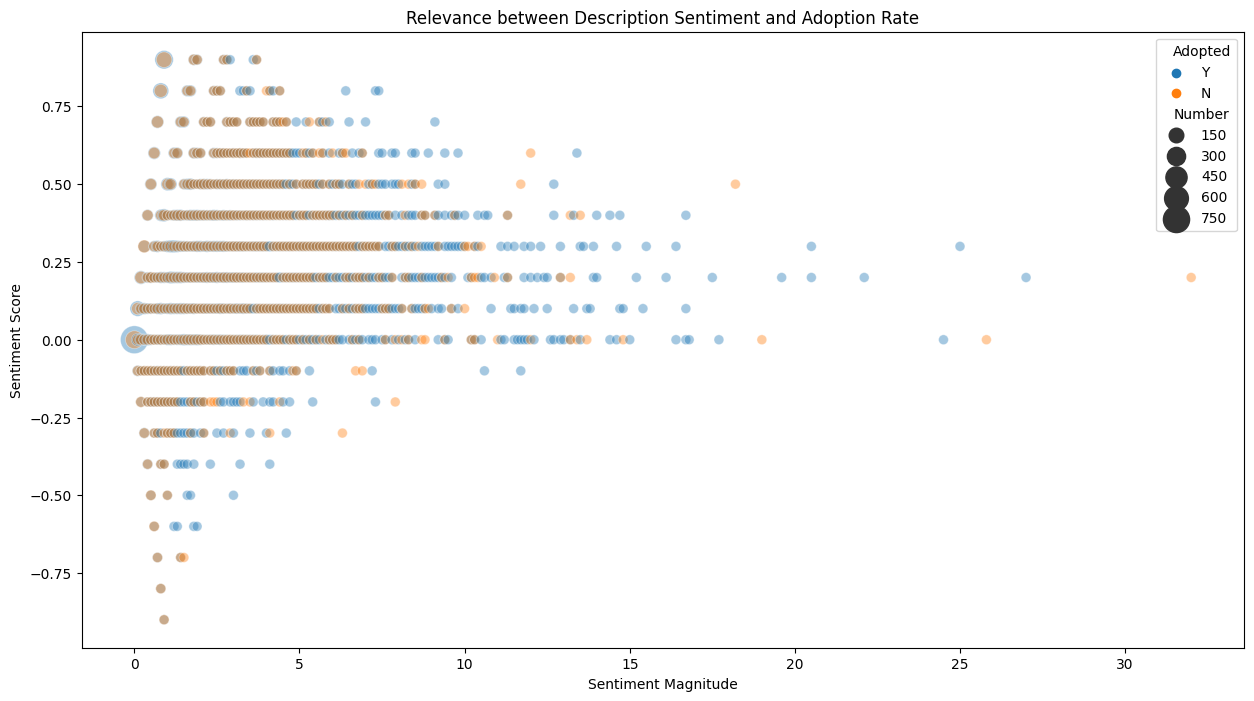

In [6]:
# make bubble plot
plt.figure(figsize=(15,8))
fig = sns.scatterplot(data=senti_df, 
                x="SentiMagnitude", 
                y="SentiScore", 
                size="Number", 
                hue="Adopted", 
                alpha=0.4,
                sizes=(50, 400))
plt.title('Relevance between Description Sentiment and Adoption Rate')
plt.xlabel('Sentiment Magnitude')
plt.ylabel('Sentiment Score')
plt.show()

## Plot Other Features

In [7]:
### pre-process the rows
plot_df = train_df.copy()
plot_df['Gender'] = train_df['Gender'] - 1
plot_df['FurLength'] = train_df['FurLength'] - 1
plot_df['Vaccinated'] = train_df['Vaccinated'] - 1
plot_df['Dewormed'] = train_df['Dewormed'] - 1
plot_df['MaturitySize'] = train_df['MaturitySize'] - 1
plot_df['Sterilized'] = train_df['Sterilized'] - 1
plot_df['Sterilized'] = train_df['Sterilized'] - 1

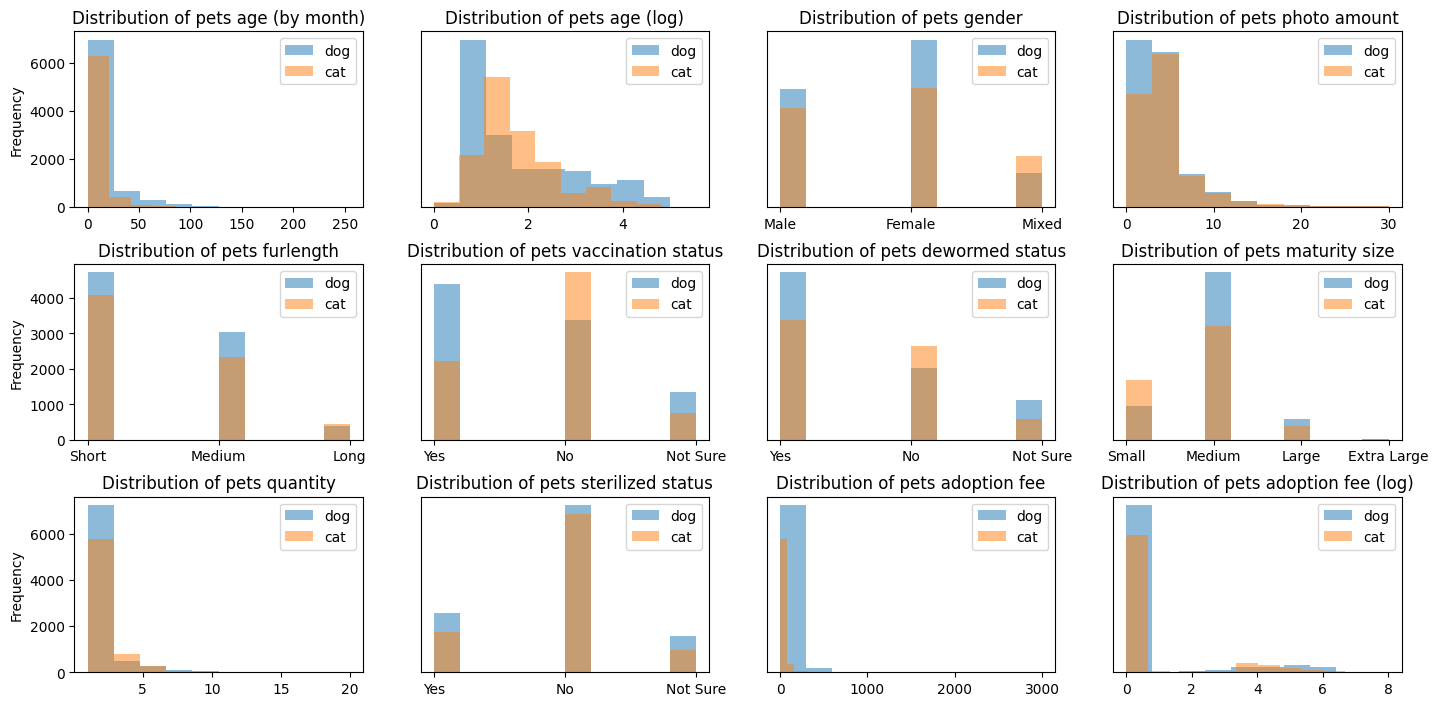

In [8]:
dog_df = plot_df[plot_df['Type'] == 1]
cat_df = plot_df[plot_df['Type'] == 2]

fig, ax = plt.subplots(nrows=3, ncols=4, figsize = (14, 7))
fig.tight_layout(h_pad=2.0)

plt.subplot(3, 4, 1)
plt.title('Distribution of pets age (by month)');
dog_df['Age'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['Age'].plot(kind='hist', label='cat', alpha=0.5);
plt.legend();

plt.subplot(3, 4, 2)
plt.title('Distribution of pets age (log)');
np.log1p(dog_df['Age']).plot(kind='hist', label='dog', alpha=0.5);
np.log1p(cat_df['Age']).plot(kind='hist', label='cat', alpha=0.5);
ax[0,1].yaxis.set_visible(False)
plt.legend();

plt.subplot(3, 4, 3)
plt.title('Distribution of pets gender');
dog_df['Gender'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['Gender'].plot(kind='hist', label='cat', alpha=0.5);
plt.xticks(range(len(plot_df.Gender.unique())), ['Male', 'Female', 'Mixed'], size='medium')
ax[0,2].yaxis.set_visible(False)
plt.legend();

plt.subplot(3, 4, 4)
plt.title('Distribution of pets photo amount');
dog_df['PhotoAmt'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['PhotoAmt'].plot(kind='hist', label='cat', alpha=0.5);
ax[0,3].yaxis.set_visible(False)
plt.legend();

plt.subplot(3, 4, 5)
plt.title('Distribution of pets furlength');
dog_df['FurLength'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['FurLength'].plot(kind='hist', label='cat', alpha=0.5);
plt.xticks(range(len(plot_df.FurLength.unique())), ['Short', 'Medium', 'Long'], size='medium')
plt.legend();

plt.subplot(3, 4, 6)
plt.title('Distribution of pets vaccination status');
dog_df['Vaccinated'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['Vaccinated'].plot(kind='hist', label='cat', alpha=0.5);
plt.xticks(range(len(plot_df.Vaccinated.unique())), ['Yes', 'No', 'Not Sure'], size='medium')
ax[1,1].yaxis.set_visible(False)
plt.legend();

plt.subplot(3, 4, 7)
plt.title('Distribution of pets dewormed status');
dog_df['Dewormed'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['Dewormed'].plot(kind='hist', label='cat', alpha=0.5);
plt.xticks(range(len(plot_df.Dewormed.unique())), ['Yes', 'No', 'Not Sure'], size='medium')
ax[1,2].yaxis.set_visible(False)
plt.legend();

plt.subplot(3, 4, 8)
plt.title('Distribution of pets maturity size');
dog_df['MaturitySize'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['MaturitySize'].plot(kind='hist', label='cat', alpha=0.5);
plt.xticks(range(len(plot_df.MaturitySize.unique())), ['Small', 'Medium', 'Large', 'Extra Large'], size='medium')
ax[1,3].yaxis.set_visible(False)
plt.legend();

plt.subplot(3, 4, 9)
plt.title('Distribution of pets quantity');
dog_df['Quantity'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['Quantity'].plot(kind='hist', label='cat', alpha=0.5);
plt.legend();

plt.subplot(3, 4, 10)
plt.title('Distribution of pets sterilized status');
dog_df['Sterilized'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['Sterilized'].plot(kind='hist', label='cat', alpha=0.5);
plt.xticks(range(len(plot_df.Sterilized.unique())), ['Yes', 'No', 'Not Sure'], size='medium')
ax[2,1].yaxis.set_visible(False)

plt.legend();

plt.subplot(3, 4, 11)
plt.title('Distribution of pets adoption fee');
dog_df['Fee'].plot(kind='hist', label='dog', alpha=0.5);
cat_df['Fee'].plot(kind='hist', label='cat', alpha=0.5);
ax[2,2].yaxis.set_visible(False)

plt.legend();

plt.subplot(3, 4, 12)
plt.title('Distribution of pets adoption fee (log)');
np.log1p(dog_df['Fee']).plot(kind='hist', label='dog', alpha=0.5);
np.log1p(cat_df['Fee']).plot(kind='hist', label='cat', alpha=0.5);
ax[2,3].yaxis.set_visible(False)
plt.legend();

## Plot Feature Correlation

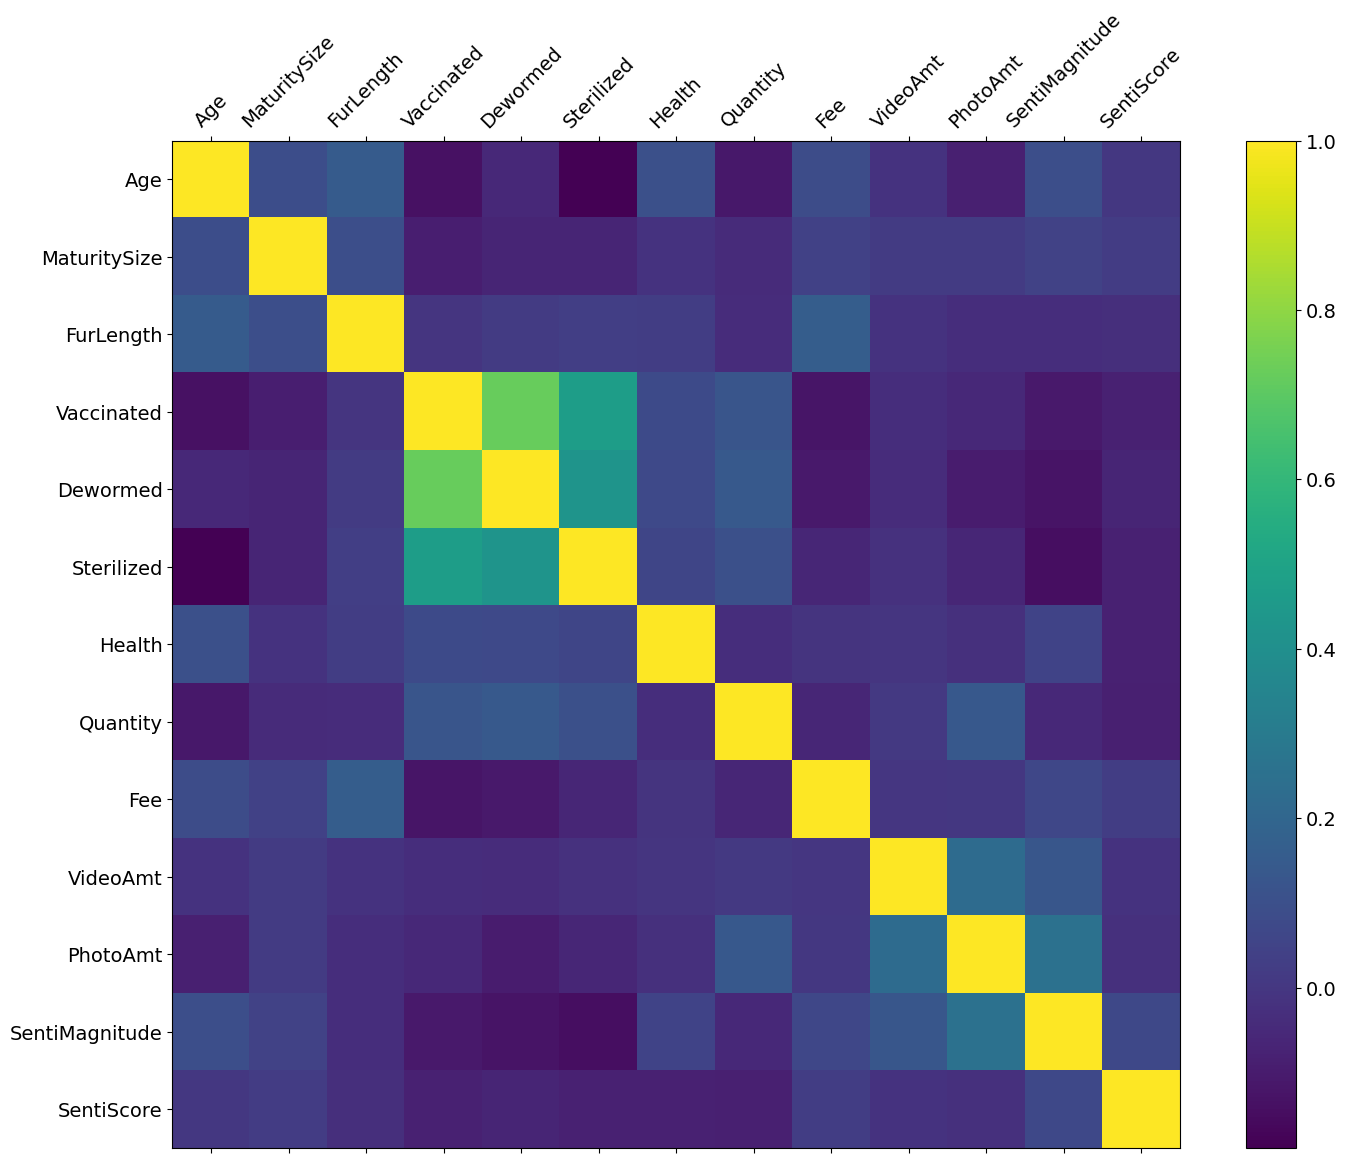

In [19]:
# drop categorical features that have no numerical meaning
cols_drop = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'State', 'Adopted']
corr_df = train_df.drop(cols_drop, axis=1)

f = plt.figure(figsize=(17, 13))
plt.matshow(corr_df.corr(), fignum=f.number)
plt.xticks(range(corr_df.select_dtypes(['number']).shape[1]), corr_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(corr_df.select_dtypes(['number']).shape[1]), corr_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)